<a href="https://colab.research.google.com/github/rajprasad001/deep_learning_concepts/blob/master/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [2]:
# The initial task was to create subsets of dataset such that we have subset 1 with instances belonging to 7 classes and subset 2
# belonging to remaining 3 classes. For the task, instances of class 0, 1 and 2 were selected for the target domain and the rest 
# were selected as source domain. Source domain was used for initial model training.

# Loading mnist digit data
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Defining class for allowing class split as mentioned above
def data_split(label, instance):
  ips = [] # instance_primary_subset = ips
  lps = [] # label_primary_subset = lps
  iss = [] # instance_secondary_subset = iss
  lss = [] # label_secondary_subset = lss
  ind = []
  for idx,item in enumerate(label):
    if item == 7 or item == 8 or item == 9:
      lss.append(label[idx])
      iss.append(instance[idx])
      ind.append(idx)
  for idx,item in enumerate(label):
    if idx not in ind:
      lps.append(label[idx])
      ips.append(instance[idx])
  ips = np.asarray(ips)
  lps = np.asarray(lps)
  iss = np.asarray(iss)
  lss = np.asarray(lss)
  return (ips,lps,iss,lss)

# Both training and testing data was split into source and target domain
x_train_prim,y_train_prim, x_train_sec,y_train_sec =  data_split(Y_train,X_train)
x_test_prim,y_test_prim,x_test_sec,y_test_sec = data_split(Y_test,X_test)

print('x_train_prim :{}'.format(x_train_prim.shape))
print('y_train_prim :{}'.format(y_train_prim.shape))
print('x_train_sec  :{}'.format(x_train_sec.shape))
print('Y_train_sec  :{}'.format(y_train_sec.shape))
print('x_test_prim  :{}'.format(x_test_prim.shape))
print('y_test_prim  :{}'.format(y_test_prim.shape))
print('x_test_sec   :{}'.format(x_test_sec.shape))
print('Y_test_sec   :{}'.format(y_test_sec.shape))



x_train_prim :(41935, 28, 28)
y_train_prim :(41935,)
x_train_sec  :(18065, 28, 28)
Y_train_sec  :(18065,)
x_test_prim  :(6989, 28, 28)
y_test_prim  :(6989,)
x_test_sec   :(3011, 28, 28)
Y_test_sec   :(3011,)


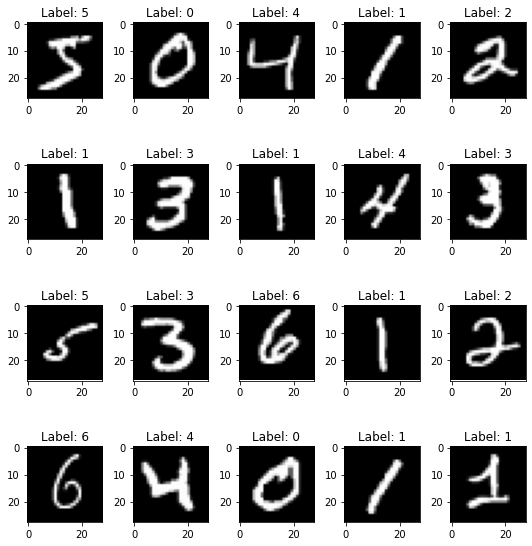

In [3]:
# Verifying the split visually and comparing the corresponding labels for the images.
num = 20
images = x_train_prim[:num]
labels = y_train_prim[:num]

num_row = 4
num_col = 5
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

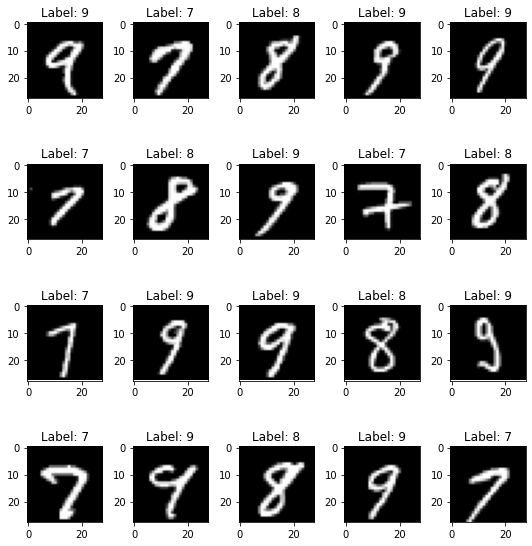

In [17]:
num = 20
images = x_train_sec[:num]
labels = y_train_sec[:num]

num_row = 4
num_col = 5
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [4]:
# The instances needs to be reshaped and standardized. The pixel value of each instance is in the range of (0, 255). To standardize the 
# values(transforming the values between 0 and 1), each pixel was standardized by 255.) 
#x_train_prim = x_train_prim.reshape(-1,28,28,1).astype("float32")/255
#x_train_sec = x_train_sec.reshape(-1,28,28,1).astype("float32")/255
#x_test_prim = x_test_prim.reshape(-1,28,28,1).astype("float32")/255
#x_test_sec = x_test_sec.reshape(-1,28,28,1).astype("float32")/255
x_train_prim = x_train_prim/255
x_train_sec = x_train_sec/255
x_test_prim = x_test_prim/255
x_test_sec = x_test_sec/255

In [5]:
# For the task of training, inception net was Densenet was used as the base model. 

def densenet(d,opt,train_x,train_y,epo,val_x,val_y):
  inputs = tf.keras.layers.Input((28,28,1))
  #initial convolution layer before the denseblock
  den0 = tf.keras.layers.Conv2D(16,3,padding='SAME',activation='relu')(inputs)
  den1 = tf.keras.layers.BatchNormalization()(den0)
  den2 = tf.keras.layers.Activation('relu')(den1)

  # Block 1
  #Each block consists of 4 convolution layers. The output of each layer is passed on to all the following layers as an input.
  den3 = tf.keras.layers.Conv2D(6,3,padding='SAME',activation='relu')(den2) # block1-Layer1: shape = 28 x 28 x 6
  den4 = tf.keras.layers.concatenate([den2,den3])# block 1- concatenation of input(den2) and layer1(den3): shape = 28 x 28 x 22
  den5 = tf.keras.layers.Conv2D(6,3,padding='SAME',activation='relu')(den4) # block1-Layer2: shape = 28 x 28 x 6
  den6 = tf.keras.layers.concatenate([den4,den5]) # block 1- concatenation of input(den2), layer1(den3) and layer2(den5): shape = 28 x 28 x 28 
  den7 = tf.keras.layers.Conv2D(6,3,padding='SAME',activation='relu')(den6) # block1-Layer3: shape = 28 x 28 x 6
  den8 = tf.keras.layers.concatenate([den6,den7]) # block 1- concatenation of input(den2), layer1(den3),layer2(den5) and layer3(den7): shape = 28 x 28 x 34
  den9 = tf.keras.layers.Conv2D(6,3,padding='SAME',activation='relu')(den8) # block1-Layer4: shape = 28 x 28 x 6
  den10 = tf.keras.layers.concatenate([den8,den9]) # block 1- concatenation of input(den2), layer1(den3),layer2(den5),layer3(den7) and layer4(den9): shape = 28 x 28 x 40

  #transition layer 1
  den11 = tf.keras.layers.Conv2D(1,3,padding='SAME',activation='relu')(den10) # shape = 28 x 28 x 1
  den12 = tf.keras.layers.AvgPool2D(2,strides=2)(den11)# shape = 14x14x1

  #Block2
  den13 = tf.keras.layers.Conv2D(12,3,padding='SAME',activation='relu')(den12)
  den14 = tf.keras.layers.concatenate([den12,den13])
  den15 = tf.keras.layers.Conv2D(12,3,padding='SAME',activation='relu')(den14)
  den16 = tf.keras.layers.concatenate([den14,den15]) 
  den17 = tf.keras.layers.Conv2D(12,3,padding='SAME',activation='relu')(den16)
  den18 = tf.keras.layers.concatenate([den16,den17])
  den19 = tf.keras.layers.Conv2D(12,3,padding='SAME',activation='relu')(den18)
  den20 = tf.keras.layers.concatenate([den18,den19])
  
  #transition layer 2
  den21 = tf.keras.layers.Conv2D(1,3,padding='SAME',activation='relu')(den20) # shape = 32 x 32 x 1
  den22 = tf.keras.layers.AvgPool2D(2,strides=2)(den21)# shape = 6x6x1
  
  #Block3
  den23 = tf.keras.layers.Conv2D(24,3,padding='SAME',activation='relu')(den22)
  den24 = tf.keras.layers.concatenate([den22,den23])
  den25 = tf.keras.layers.Conv2D(24,3,padding='SAME',activation='relu')(den24)
  den26 = tf.keras.layers.concatenate([den24,den25]) 
  den27 = tf.keras.layers.Conv2D(24,3,padding='SAME',activation='relu')(den26)
  den28 = tf.keras.layers.concatenate([den26,den27])
  den29 = tf.keras.layers.Conv2D(24,3,padding='SAME',activation='relu')(den28)
  den30 = tf.keras.layers.concatenate([den28,den29])

  #classifictaion layer
  den31 = tf.keras.layers.AvgPool2D(2,strides=2)(den30)
  den32 = tf.keras.layers.Flatten()(den31)
  output = tf.keras.layers.Dense(d,activation='softmax')(den32)
  
  model = tf.keras.Model(inputs,output)
  model.summary()

  model.compile(optimizer=opt,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
  history = model.fit(train_x, train_y, epochs=epo, validation_data=(val_x, val_y))
  
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0, 1])
  plt.legend(loc='lower right')
  return model

  #test_loss, test_acc = model.evaluate(test_x,  test_y, verbose=2)
  #print('Test Data Loss : {}, Test Data Accuracy : {}'.format(test_loss,test_acc))


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 28, 28, 16)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

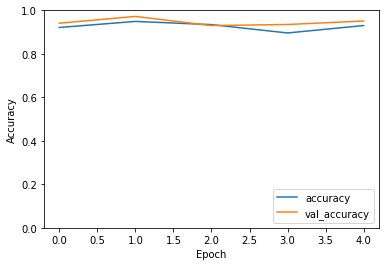

In [6]:
source_domain= densenet(7,'adam',x_train_prim,y_train_prim,5,x_test_prim,y_test_prim)

In [20]:
#source_domain.trainable = True
source_domain.trainable = False
base_inputs = source_domain.layers[0].input
base_outputs = source_domain.layers[-2].output
target_output = tf.keras.layers.Dense(10)(base_outputs)
target_model = tf.keras.Model(inputs = base_inputs, outputs = target_output)
print(target_model.summary())

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 28, 28, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________

In [11]:
# The training is done on the source domain model but except the last dense layer. For the purpose of comparision the pretrained model's parameters were 
# trainable. As the result indicates, the accuracy is high and time taken for traininig is 180s on an average for 5 epochs.
target_model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
history = target_model.fit(x_train_sec, y_train_sec, epochs=5, validation_data=(x_test_sec, y_test_sec))

Epoch 1/5
565/565 [==============================] - 185s 328ms/step - loss: 1.1294 - accuracy: 0.9412 - val_loss: 0.0980 - val_accuracy: 0.9645
Epoch 2/5
565/565 [==============================] - 186s 330ms/step - loss: 0.0689 - accuracy: 0.9786 - val_loss: 0.0597 - val_accuracy: 0.9807
Epoch 3/5
565/565 [==============================] - 183s 323ms/step - loss: 0.0446 - accuracy: 0.9853 - val_loss: 0.0493 - val_accuracy: 0.9834
Epoch 4/5
565/565 [==============================] - 180s 318ms/step - loss: 0.0296 - accuracy: 0.9900 - val_loss: 0.0377 - val_accuracy: 0.9900
Epoch 5/5
565/565 [==============================] - 179s 317ms/step - loss: 0.0244 - accuracy: 0.9916 - val_loss: 0.0410 - val_accuracy: 0.9861


In [21]:
# The training is done by keeping the trainable parameters of the source domain as false and only the final dense layer is allowed to train.
# The accuracy is comparable but the training time is reduced to 1/3rd of the original time taken.
target_model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
history = target_model.fit(x_train_sec, y_train_sec, epochs=5, validation_data=(x_test_sec, y_test_sec))

Epoch 1/5
565/565 [==============================] - 58s 103ms/step - loss: 0.2744 - accuracy: 0.9479 - val_loss: 0.0481 - val_accuracy: 0.9824
Epoch 2/5
565/565 [==============================] - 58s 103ms/step - loss: 0.0412 - accuracy: 0.9864 - val_loss: 0.0480 - val_accuracy: 0.9824
Epoch 3/5
565/565 [==============================] - 59s 104ms/step - loss: 0.0295 - accuracy: 0.9901 - val_loss: 0.0329 - val_accuracy: 0.9907
Epoch 4/5
565/565 [==============================] - 58s 103ms/step - loss: 0.0289 - accuracy: 0.9909 - val_loss: 0.0447 - val_accuracy: 0.9890
Epoch 5/5
565/565 [==============================] - 58s 103ms/step - loss: 0.0267 - accuracy: 0.9915 - val_loss: 0.0399 - val_accuracy: 0.9907
